## A) Import lib

In [1]:
from DataSet import DataSet
from SimGPBO_old import SimGPBO_old
from SimGPBO import SimGPBO
from PostProcessor import PostProcessor
import GPy
import numpy as np 
import matplotlib.pyplot as plt
import copy 
import torch 
import gpytorch
from GPcustom.models import GPytorchModel

In [2]:
def plot_map(ds: DataSet, vector: np.array, title: str=None) -> None:
    map = np.full((
                        np.max(ds.set['ch2xy'][:,0]),
                        np.max(ds.set['ch2xy'][:,1])
                        ), 
                        np.nan)
    for i in range(ds.set['ch2xy'].shape[0]):
        map[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = vector[i]

    # Loop over each cell of the matrix to display the value in the center of the cell
    for i in range(map.shape[0]):
        for j in range(map.shape[1]):
            plt.text(j, i, f"{map[i, j]:.3g}", ha='center', va='center', color="white", fontsize=8)

    plt.figure()
    plt.imshow(map, cmap='viridis', vmin=np.nanmin(map), vmax=np.nanmax(map))
    plt.colorbar(label="values")
    plt.title(title)
    plt.show()


In [45]:
def map_plot(my_map, title: str = 'map', figsize=(6, 6)):
    """
    Plots a 2D map with color scale and values displayed at each cell.

    This function visualizes a 2D matrix (`my_map`) using a color map, with the values of the 
    matrix displayed at each corresponding location. The color range is automatically scaled 
    to the minimum and maximum values of the matrix, and a color bar is included to indicate 
    the value scale. The function allows customization of the plot title.

    Args:
        my_map (numpy.ndarray): A 2D numpy array to be plotted.
        title (str, optional): The title of the plot. Default is 'map'.

    Returns:
        None: The function displays the plot but does not return anything.
    
    Example:
        map_plot(np.array([[1, 2], [3, 4]]), 'Sample Map')
    """
    # Set up the figure with a fixed size
    # plt.figure(figsize=figsize)
    
    # Display the map using a color map and scale it according to the minimum and maximum values
    plt.imshow(my_map, cmap='coolwarm', vmin=np.nanmin(my_map), vmax=np.nanmax(my_map))
    
    # Add a color bar to indicate the value scale
    plt.colorbar(label="values")
    
    # Set the title of the plot
    plt.title(title)

    # # Loop over each cell of the matrix to display the value in the center of the cell
    # for i in range(my_map.shape[0]):
    #     for j in range(my_map.shape[1]):
    #         plt.text(j, i, f"{my_map[i, j]:.3g}", ha='center', va='center', color="white", fontsize=8)

    # Show the plot
    plt.show()

## B) Import data

In [3]:
ds = DataSet('../data/','nhp','Cebus1_M1_190221.mat','cebus1')
ds.load_matlab_data() # load data from the dataset_file

## C) Simulation 

### C.1) simulation "OG" with gpytorch

In [3]:
sim = SimGPBO(name = 'ttest_og_', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 1,
                    NB_IT = 15,
                    KAPPA = 6,
                    NB_RND = 1
                    )

sim.select_emgs([0])

sim.run_simulations(gp_origin='gpytorch', response_type='valid', 
                         hyperparams_storage=True, HP_estimation=True, manual_seed=True, outputscale=1., noise=0.01)

Global Progress:   0%|          | 0/1 [00:00<?, ?iter/s]

Global Progress: 100%|██████████| 1/1 [00:16<00:00, 16.65s/iter]

Elapsed time: 16.656370639801025 seconds
final save of ttest_og_ in:   results/gpbo_gpytorch_UCB_cebus1_ttest_og_.npz


### C.2) simulation with gpytorch using QueriesInfo to predict (and to optimize the HPs)

In [5]:
sim = SimGPBO(name = 'ttest_pseudo_gpy_', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 1,
                    NB_IT = 15,
                    KAPPA = 6,
                    NB_RND = 1
                    )

sim.select_emgs([0])

sim.run_simulations(gp_origin='estimated_gpytorch', response_type='valid', 
                         hyperparams_storage=True, HP_estimation=False, manual_seed=True, 
                         outputscale=None, noise=None,
                         max_iters_training_gp=10)

Global Progress: 100%|██████████| 1/1 [00:05<00:00,  5.30s/iter]

Elapsed time: 5.30698561668396 seconds
final save of ttest_pseudo_gpy_ in:   results/gpbo_estimated_gpytorch_UCB_cebus1_ttest_pseudo_gpy_.npz


### C.3) simulation with gpytorch using QueriesInfo to optimize the HPs

In [8]:
sim = SimGPBO(name = 'ttest_pseudo_hp_', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 1,
                    NB_IT = 15,
                    KAPPA = 6,
                    NB_RND = 1
                    )

sim.select_emgs([0])

sim.run_simulations(gp_origin='estimated_hp_gpytorch', response_type='valid', 
                         hyperparams_storage=True, HP_estimation=False, manual_seed=True, outputscale=1., noise=0.01)

Global Progress: 100%|██████████| 1/1 [00:07<00:00,  7.68s/iter]

Elapsed time: 7.680302381515503 seconds
final save of ttest_pseudo_hp_ in:   results/gpbo_estimated_hp_gpytorch_UCB_cebus1_ttest_pseudo_hp_.npz


### C.4) simulation with NN

In [13]:
sim = SimGPBO(name = 'ttest_NN_KAPPA8', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 20,
                    NB_IT = 200,
                    KAPPA = 8,
                    NB_RND = 1
                    )

# sim.select_emgs([0])

sim.run_simulations(gp_origin='NN', response_type='mean', manual_seed=True)

Global Progress: 100%|██████████| 120/120 [09:58<00:00,  4.98s/iter]

Elapsed time: 598.1920092105865 seconds
final save of ttest_NN_KAPPA8 in:   results/gpbo_NN_UCB_cebus1_ttest_NN_KAPPA8.npz


In [14]:
sim = SimGPBO(name = 'ttest_NN_KAPPA10', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 20,
                    NB_IT = 200,
                    KAPPA = 10,
                    NB_RND = 1
                    )

# sim.select_emgs([0])

sim.run_simulations(gp_origin='NN', response_type='mean', manual_seed=True)

Global Progress: 100%|██████████| 120/120 [31:14<00:00, 15.62s/iter]

Elapsed time: 1874.401404619217 seconds
final save of ttest_NN_KAPPA10 in:   results/gpbo_NN_UCB_cebus1_ttest_NN_KAPPA10.npz


In [ ]:
sim = SimGPBO(name = 'ttest_NN_KAPPA6_valid', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 20,
                    NB_IT = 200,
                    KAPPA = 6,
                    NB_RND = 1
                    )

# sim.select_emgs([0])

sim.run_simulations(gp_origin='NN', response_type='valid', manual_seed=True)

Global Progress: 100%|██████████| 120/120 [21:24<00:00, 10.71s/iter]

Elapsed time: 1284.895881652832 seconds
final save of ttest_NN_KAPPA6_valid in:   results/gpbo_NN_UCB_cebus1_ttest_NN_KAPPA6_valid.npz


In [16]:
sim = SimGPBO(name = 'ttest_NN_KAPPA8_valid', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 20,
                    NB_IT = 200,
                    KAPPA = 8,
                    NB_RND = 1
                    )

# sim.select_emgs([0])

sim.run_simulations(gp_origin='NN', response_type='valid', manual_seed=True)

Global Progress: 100%|██████████| 120/120 [11:01<00:00,  5.52s/iter]

Elapsed time: 661.8319180011749 seconds
final save of ttest_NN_KAPPA8_valid in:   results/gpbo_NN_UCB_cebus1_ttest_NN_KAPPA8_valid.npz


In [17]:
sim = SimGPBO(name = 'ttest_NN_KAPPA10_valid', 
                    ds = copy.deepcopy(ds),
                    AF = 'UCB',
                    NB_REP = 20,
                    NB_IT = 200,
                    KAPPA = 10,
                    NB_RND = 1
                    )

# sim.select_emgs([0])

sim.run_simulations(gp_origin='NN', response_type='valid', manual_seed=True)

Global Progress: 100%|██████████| 120/120 [08:38<00:00,  4.32s/iter]

Elapsed time: 518.4789094924927 seconds
final save of ttest_NN_KAPPA10_valid in:   results/gpbo_NN_UCB_cebus1_ttest_NN_KAPPA10_valid.npz


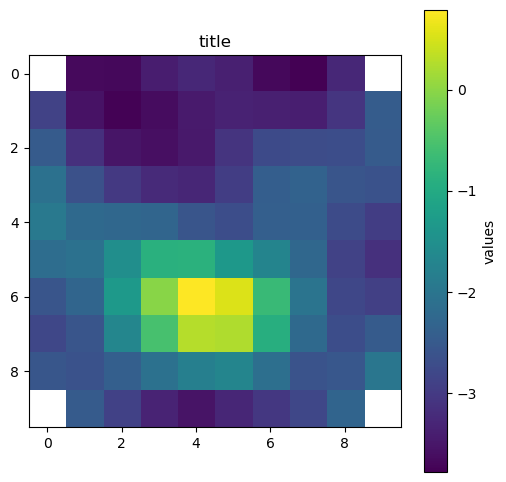

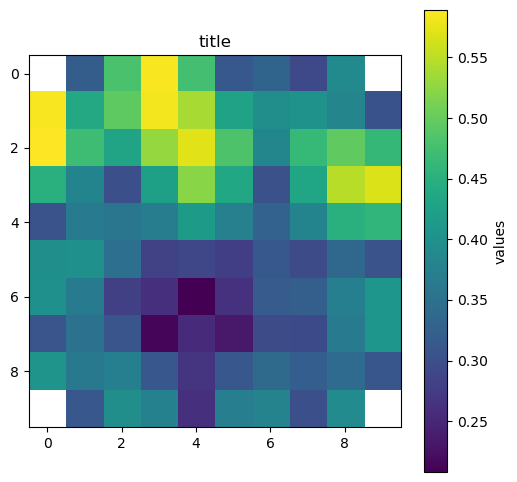

In [7]:
map = np.full((
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,1])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = sim.gp.mean[i]

# print(map)
# # Loop over each cell of the matrix to display the value in the center of the cell
# for i in range(map.shape[0]):
#     for j in range(map.shape[1]):
#         plt.text(j, i, f"{map[i, j]:.3g}", ha='center', va='center', color="white", fontsize=8)
 
plt.figure(figsize=(6, 6))
plt.imshow(map, cmap='viridis', vmin=np.nanmin(map), vmax=np.nanmax(map))
plt.colorbar(label="values")
plt.title("title")
plt.show()

map = np.full((
                    np.max(ds.set['ch2xy'][:,0]),
                    np.max(ds.set['ch2xy'][:,1])
                    ), 
                    np.nan)
for i in range(ds.set['ch2xy'].shape[0]):
    map[int(ds.set['ch2xy'][i,0]-1),int(ds.set['ch2xy'][i,1]-1)] = sim.gp.std[i]

# print(map)
# # Loop over each cell of the matrix to display the value in the center of the cell
# for i in range(map.shape[0]):
#     for j in range(map.shape[1]):
#         plt.text(j, i, f"{map[i, j]:.3g}", ha='center', va='center', color="white", fontsize=8)
 
plt.figure(figsize=(6, 6))
plt.imshow(map, cmap='viridis', vmin=np.nanmin(map), vmax=np.nanmax(map))
plt.colorbar(label="values")
plt.title("title")
plt.show()

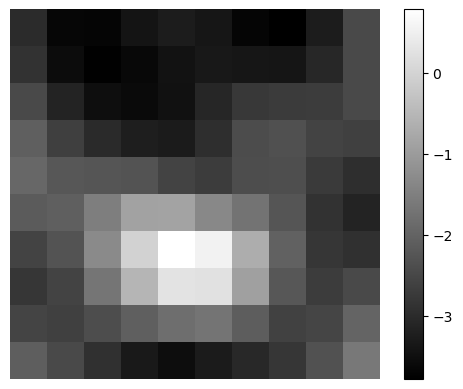

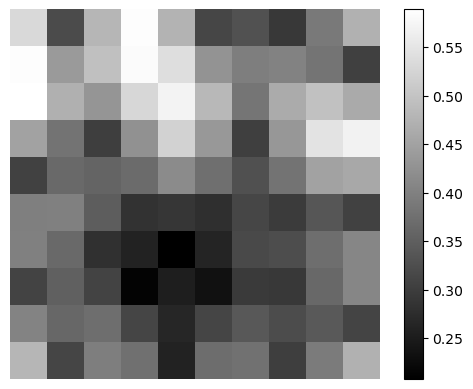

In [10]:
plot_tensor_image(sim.gp.img_mean.detach())
plot_tensor_image(sim.gp.img_std.detach())